# Face Recognition

Lets get a overview of steps in performing face recognition.
- Data preprocessing using `opencv` on raw images data to get feature vectors.
- Dimensionality reduction using `PCA` of image feature vectors.
- Modeling using `1-NN`.
  
------

Lets import all the required modules,
- In the below cell, to choose top `x` eigen values change the n_components variable
- Choose `image_vector_size` as you needed which indicates the resize pixels of image.
- `n_training_folders` indicates number of folders in training face_data.
- `m_training_images` indicates images in each `n_training_folders`.
- `n_testing_folders` indicates number of folders in testing face_data.
- `m_testing_images` indicates images in each `n_testing_folders`.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dimensionality_reduction import PCA
from neighbors import KNeighborsClassifier
from preprocess import Preprocessor


n_components = 5
image_vector_size = 100

n_training_folders = 10
m_training_images = 10

n_testing_folders = 10
m_testing_images = 3

## Data preprocessing

Now lets create our own data `Preprocessor` class which takes training, testing and cascade paths as input and returns us the image vectors of rect (here face) with labels according to the given haarcascade. 

To visualize the face vectors in a image format lets write a small plot portraits function which prints all the faces with provided labels in a subplot manner using provided number of columns and number of rows.

In [24]:
def plot_portraits(images, titles, h, w, n_row, n_col):
    """
    Method which plots the array of images in a subplot manner
    images: array of image vectors
    title: image labels
    h: rows of image vector
    w: columns of image vector
    n_row: number of rows in subplot
    n_col: number of columns in subplot
    """
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap="gray")
        plt.title(titles[i], color="black")
        plt.xticks(())
        plt.yticks(())

Since we got our required preprocessing data preprocessing function and a portrait visualizer lets get our training and testing data and visualize those gray scaled images to proceed further.

In [25]:
training_path = "Data/Train"
testing_path = "Data/Test"
harcascade_frontal_face_path = "Cascades/haarcascade_frontalface_alt.xml"

preprocess = Preprocessor(training_path, testing_path, cascade_path = harcascade_frontal_face_path, image_vector_size = image_vector_size)

faces_train, labels_train = preprocess.get_train_data()
faces_test, labels_test = preprocess.get_test_data()
n_samples_train, h, w = faces_train.shape
n_samples_test, h, w = faces_test.shape

Now lets visualize our training dataset images which are preprocessed with opencv to gray scale images using `plot_portraits` function.

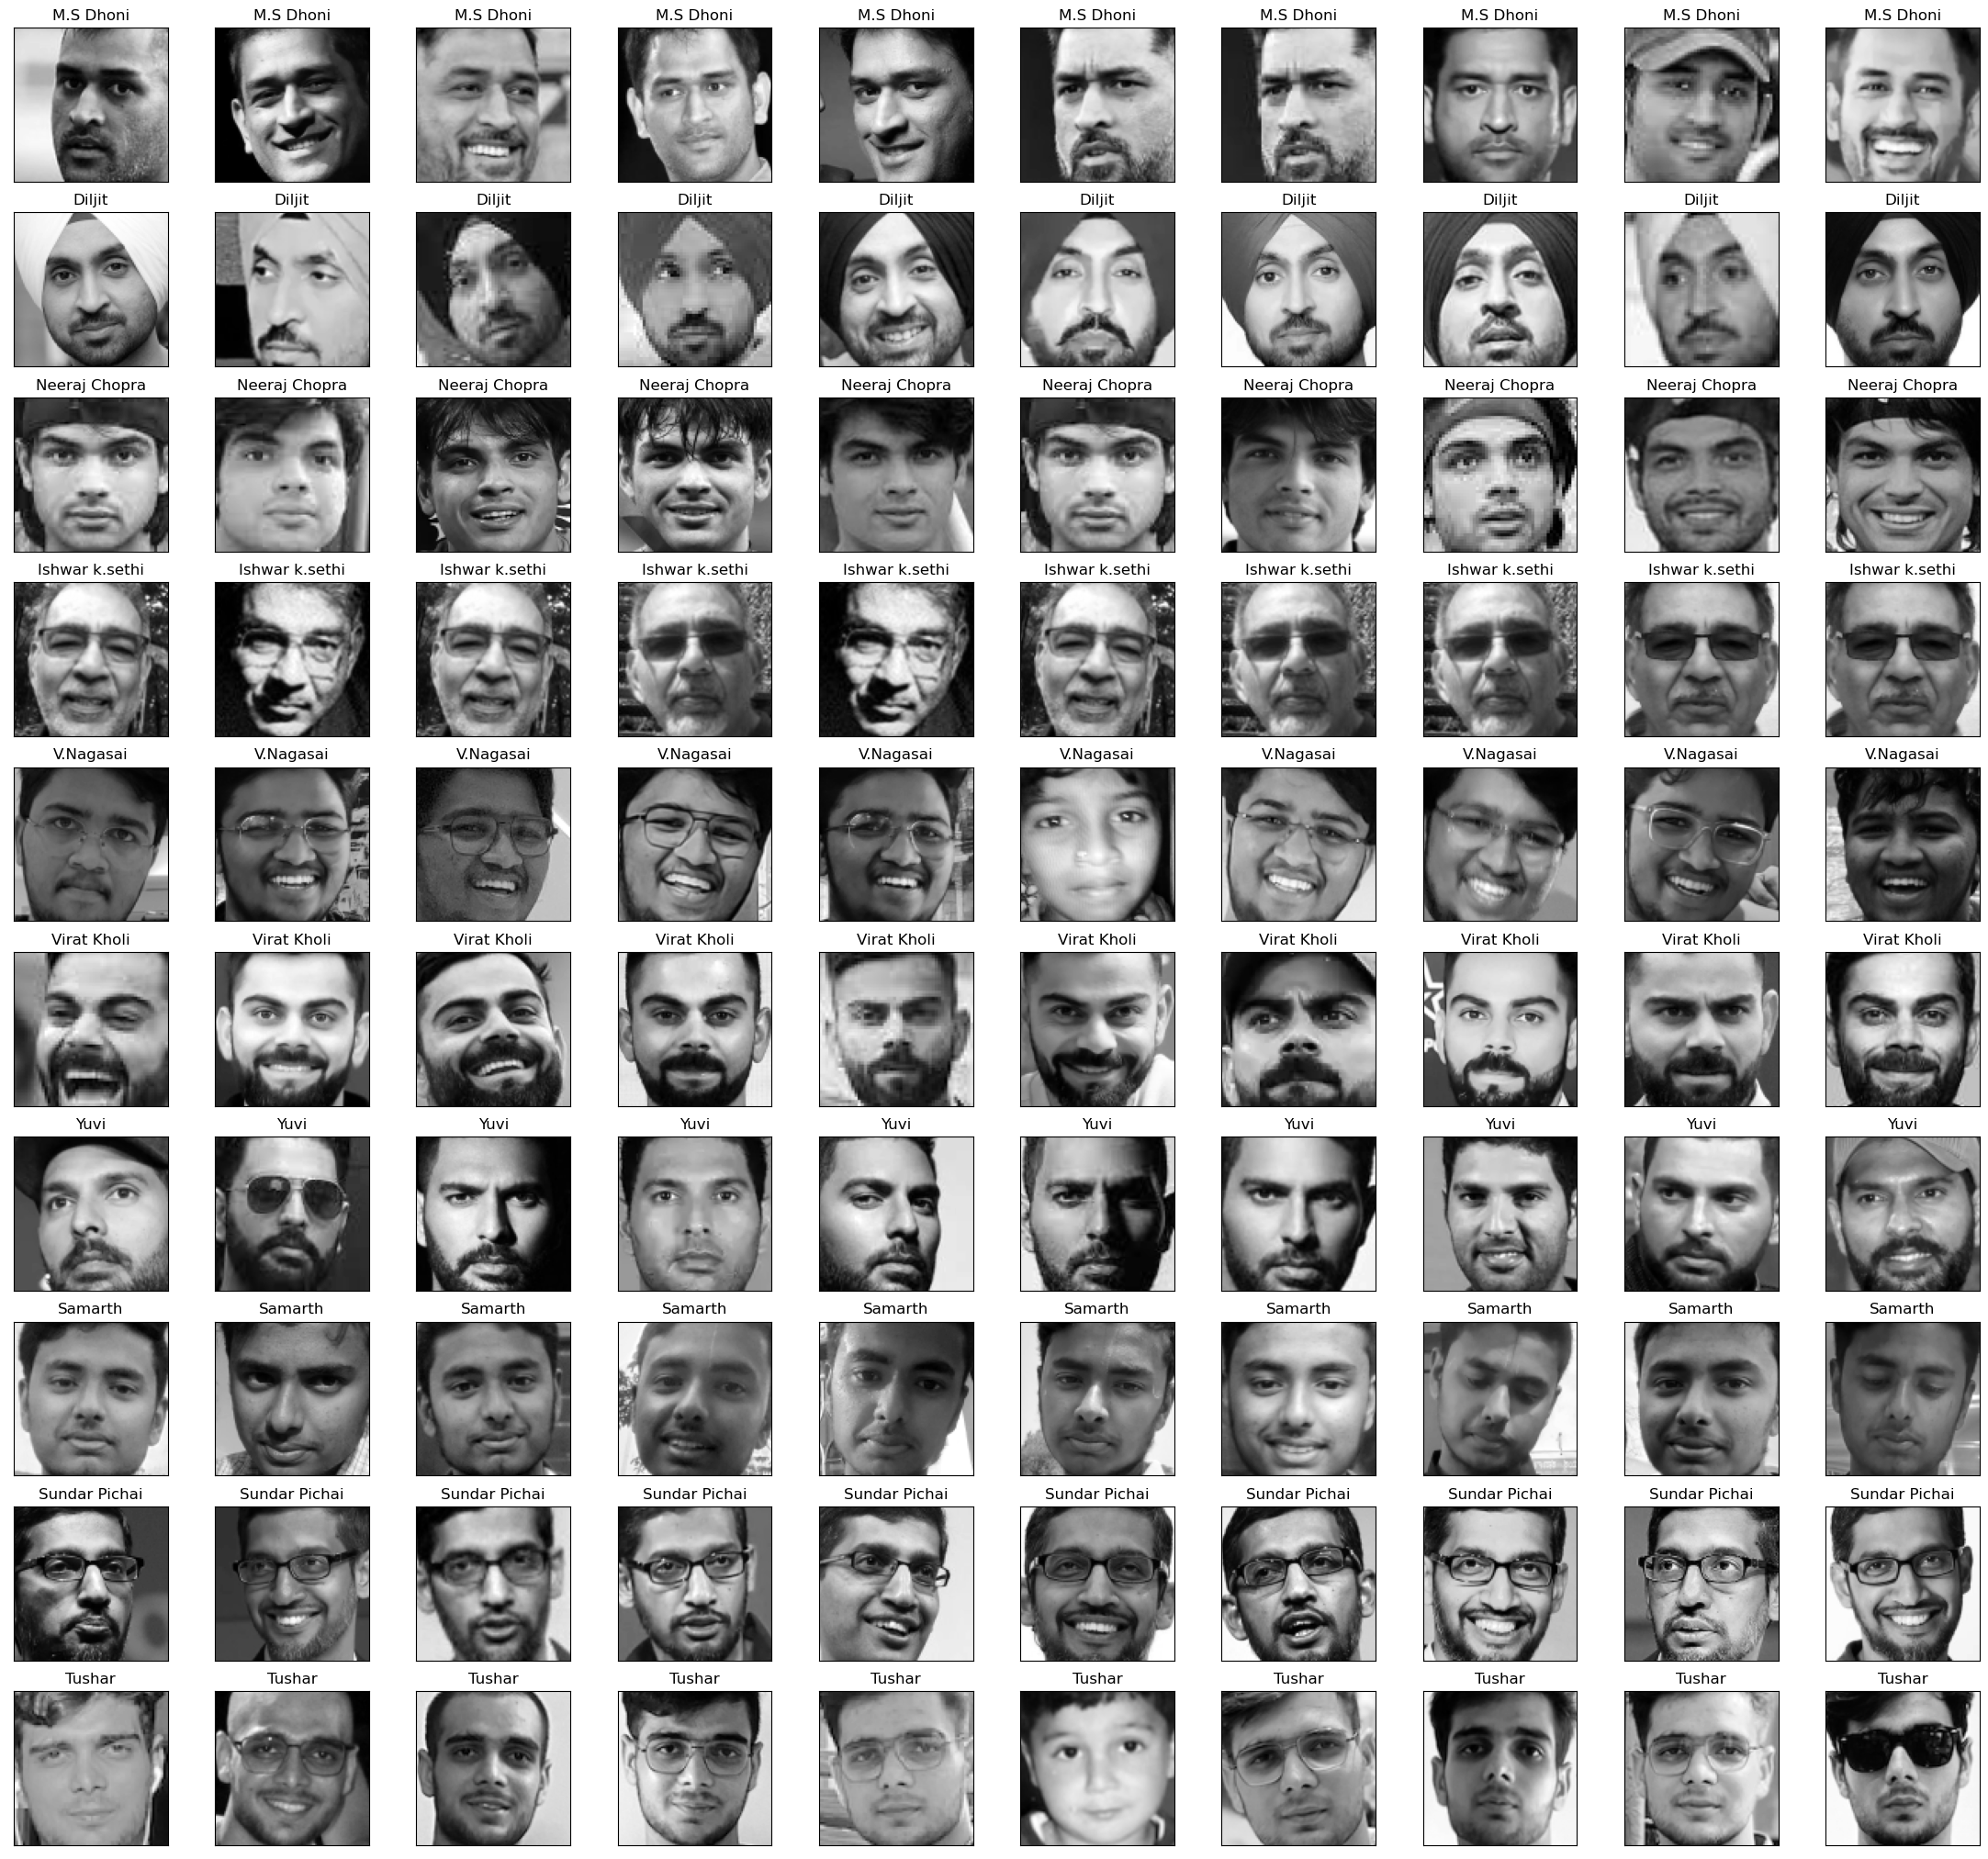

In [26]:
plot_portraits(faces_train, labels_train, h, w, n_row = 10, n_col = 10)

## Dimensionality reduction

As we got our own PCA, lets fit the data and get eigen faces

In [27]:
data_train = faces_train.reshape(n_samples_train, h*w)
pca = PCA(n_components=n_components)
eig_vec_train, eig_faces_train = pca.fit(data_train.T) 

(5, 100) (5, 10000)


In the above cell, 
- `C` represents top `n_components` of eigen vectors.
- `P` represent the projection of those `C` eigen vectors into eigen space which are nothing but top `n_components` facial representation of given face data.
- `M` represents mean vector of the given data.
- `N` represent the normalized representation of data that is unique representation of each face excluding common among all faces.

Now lets visualize these eigen faces using `plot_portrait` function

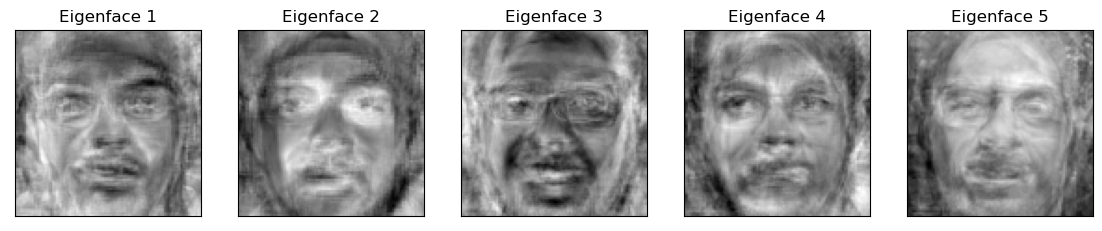

In [28]:
eig_titles_train = [f"Eigenface {i+1}" for i in range(eig_faces_train.shape[0])]
plot_portraits(eig_faces_train, eig_titles_train, h, w, 1, 5)

For the lower dimensional representation of our data lets transform using the pca and store it with their corresponding labels for modeling.

In [29]:
reduced_train_data = pca.transform(data_train.T)
training_data = pd.DataFrame(reduced_train_data) 
training_data["labels"] = labels_train
X_train = training_data[[column for column in training_data.columns if column != "labels"]]
y_train = training_data["labels"]
training_data.head()

0             1             2             3             4  \
0  1.413954e+07 -1.822048e+07  2.000196e+07 -1.967391e+07 -2.442268e+07   
1 -8.522279e+06  8.216522e+06 -1.841402e+07  1.357927e+07  2.255265e+07   
2  6.009157e+06 -4.076925e+06  9.966715e+06 -7.473537e+06 -8.647913e+06   
3 -1.109117e+06  8.375938e+06 -3.465763e+06  3.184875e+06  1.592101e+07   
4 -4.312384e+06  5.232337e+06 -9.219623e+06  2.026599e+06  1.656628e+07   

      labels  
0  M.S Dhoni  
1  M.S Dhoni  
2  M.S Dhoni  
3  M.S Dhoni  
4  M.S Dhoni

## Inverse transformation of faces

To get the whole data use these `n_components` eigen faces and generate whole data using the mean vector by multiplying projections of top `n_components` principal components. And also lets visualize the inverse transformed images.

(100, 5) (5, 10000) (10000, 1)


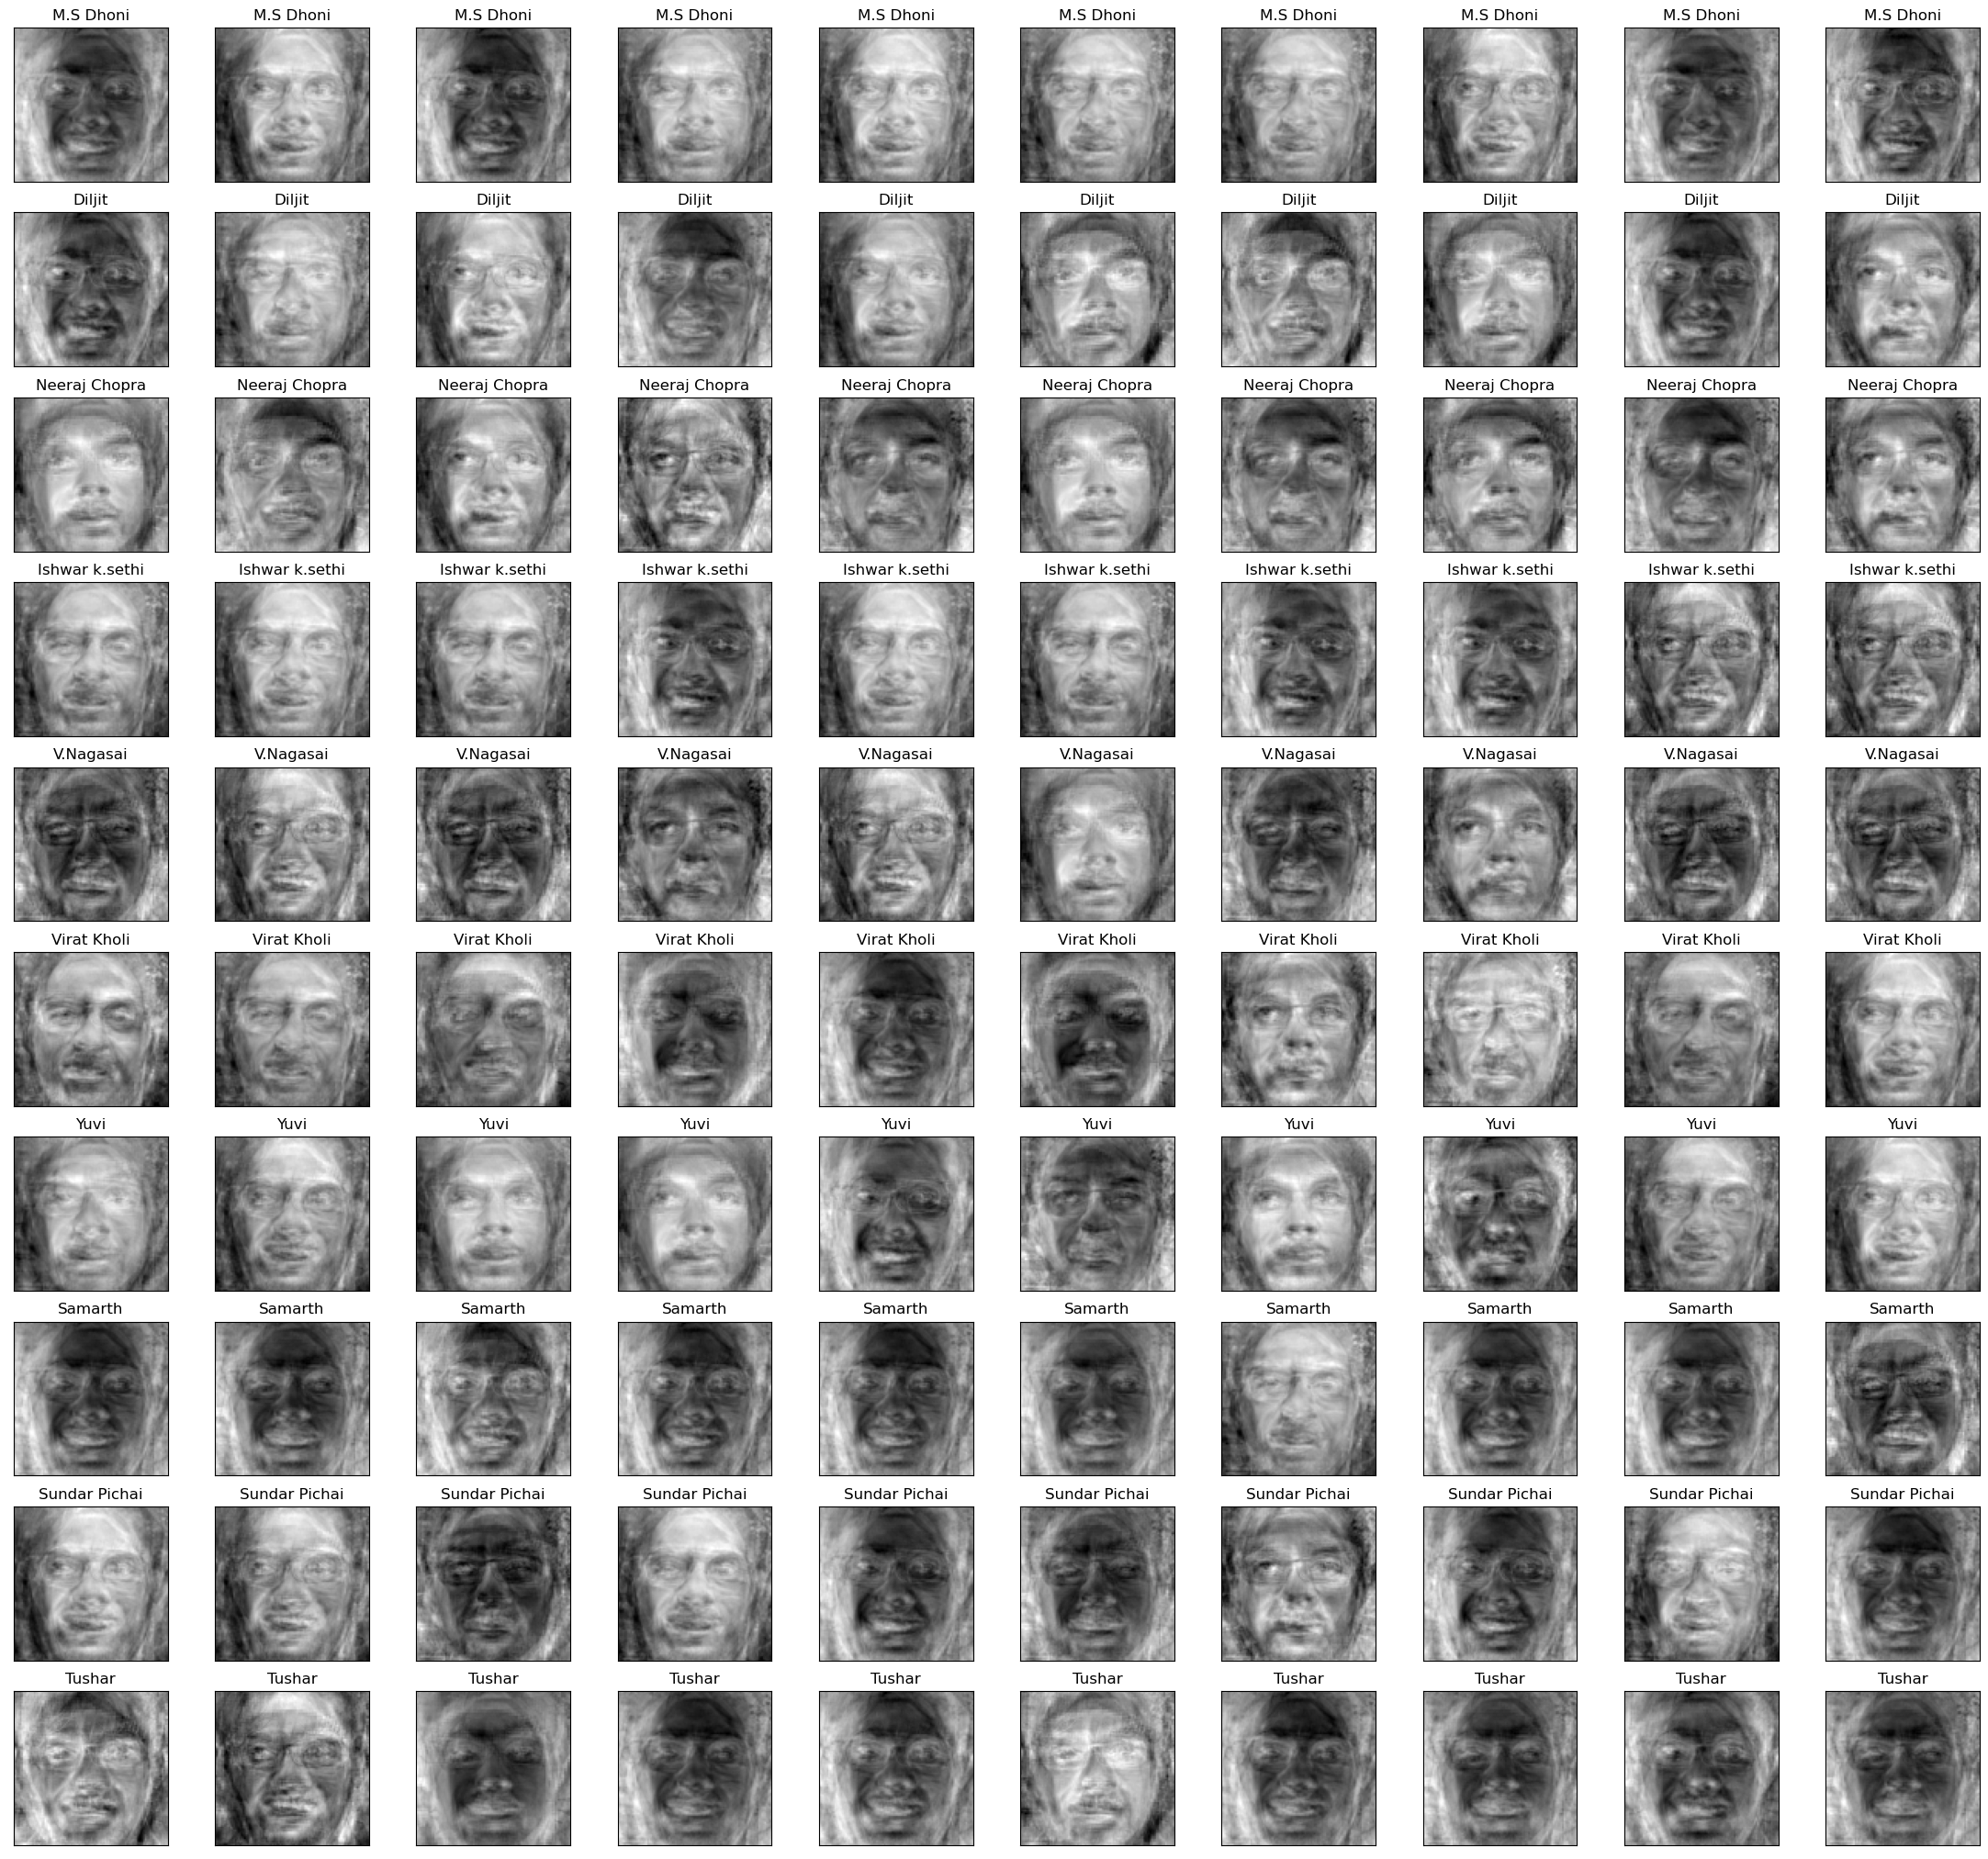

In [30]:
eig_faces_inverse_train = pca.inverse_transform(reduced_train_data)
plot_portraits(eig_faces_inverse_train, labels_train, h, w, 10, 10)

(30, 5) (5, 10000) (10000, 1)


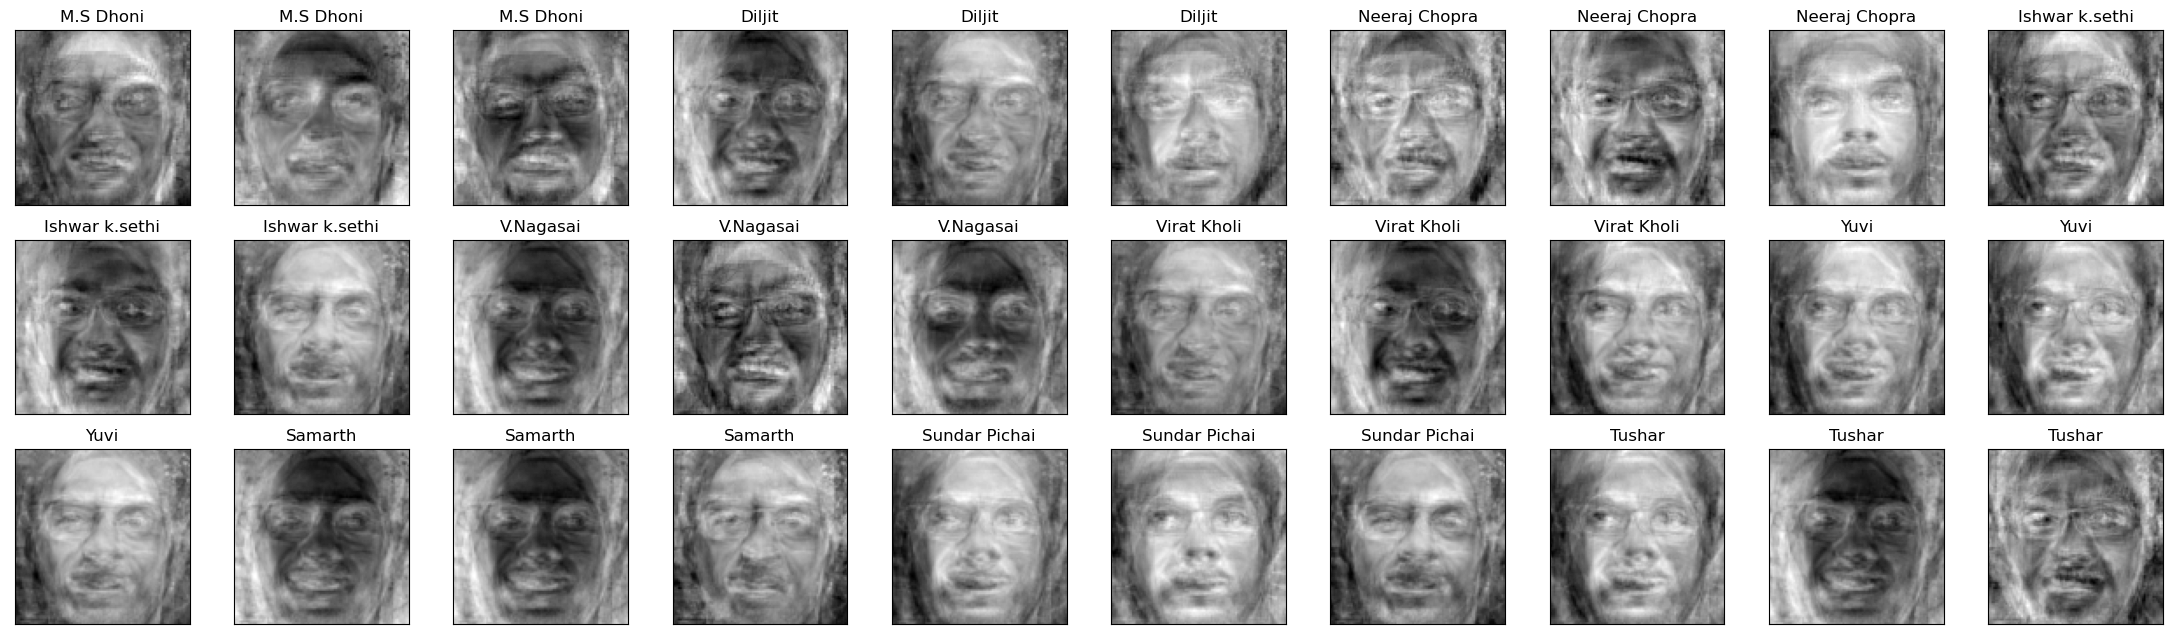

In [31]:
data_test = faces_test.reshape(n_samples_test, h*w)
reduced_test_data = pca.transform(data_test.T)
test_data = pd.DataFrame(reduced_test_data)
test_data["labels"] = labels_test
X_test = test_data[[column for column in test_data.columns if column != "labels"]]
y_test = test_data["labels"]

## ----- Inverse transformation of test data -----
eig_faces_inverse_test = pca.inverse_transform(reduced_test_data)
plot_portraits(eig_faces_inverse_test, labels_test, h, w, 3, 10)

Since we got both training and test data in required dimension format lets build a model to classify these.

## Modeling with 1-NN

Let us define our own KNN classifier which detects based on the euclidean distance metric.

In [32]:

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy score using 1-NN: {score}")

Accuracy score using 1-NN: 0.36666666666666664


# PCA with Normalization

In [33]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
scalar.fit(data_train)
data_train_norm = scalar.transform(data_train)
data_test_norm = scalar.transform(data_test)

pca = PCA(n_components=n_components)
pca.fit(data_train_norm.T)
reduced_train_data = pca.transform(data_train_norm.T)
training_data = pd.DataFrame(reduced_train_data) 
training_data["labels"] = labels_train
X_train = training_data[[column for column in training_data.columns if column != "labels"]]
y_train = training_data["labels"]
reduced_test_data = pca.transform(data_test_norm.T)
test_data = pd.DataFrame(reduced_test_data)
test_data["labels"] = labels_test
X_test = test_data[[column for column in test_data.columns if column != "labels"]]
y_test = test_data["labels"]


clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy score using 1-NN: {score}")

(5, 100) (5, 10000)
Accuracy score using 1-NN: 0.26666666666666666


## Using builtin PCA

In [34]:
from sklearn.decomposition import PCA

# Dimensionality reduction
pca_inbuilt = PCA(n_components = n_components)
pca_inbuilt.fit(data_train)
X_train_builtin = pd.DataFrame(pca_inbuilt.transform(data_train))
X_test_builtin = pd.DataFrame(pca_inbuilt.transform(data_test))


clf = KNeighborsClassifier(n_neighbors = 1)
clf.fit(X_train_builtin, y_train)
score = clf.score(X_test_builtin, y_test)
print(f"Accuracy score using 1-NN without normalization: {score}")


#With normalization
pca_inbuilt_norm = PCA(n_components = n_components)
pca_inbuilt_norm.fit(data_train_norm)
X_train_builtin = pd.DataFrame(pca_inbuilt_norm.transform(data_train_norm))
X_test_builtin = pd.DataFrame(pca_inbuilt_norm.transform(data_test_norm))


clf = KNeighborsClassifier(n_neighbors = 1)
clf.fit(X_train_builtin, y_train)
score = clf.score(X_test_builtin, y_test)
print(f"Accuracy score using 1-NN with normalization: {score}")



Accuracy score using 1-NN without normalization: 0.2
Accuracy score using 1-NN without normalization: 0.3


Visualization of variance distribution among principal components

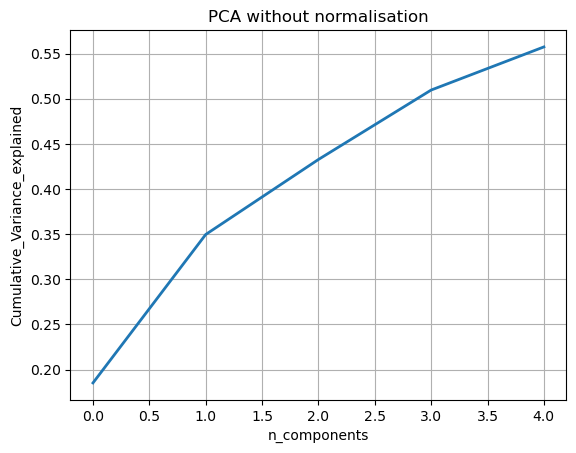

In [40]:
# PCA principal components variation visualization
percentage_var_explained = pca_inbuilt.explained_variance_ratio_;  
cum_var_explained=np.cumsum(percentage_var_explained)

fig, axes = plt.subplots(1, 2)
plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(cum_var_explained,linewidth=2)  
plt.axis('tight')  
plt.grid() 
plt.title("PCA without normalisation")
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()



## Using Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy score using Logistic regression: {score}")

Accuracy score using Logistic regression: 0.3333333333333333


/Users/nagasaivegur/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Using LDA

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy score using LDA: {score}")

Accuracy score using LDA: 0.4
